## A 2D Flow matching implementation

**Generative learning.** Let $D \subset \mathbb{R}^d$ be a finite set of points which we will call a dataset. 
Assume that any point $x \in D$ is drawn from a continuous probability law $x \sim p_{\mathrm{data}}$, and that we have no other knowledge on $p_{\mathrm{data}}$ than the samples contained in the dataset $D$.
The goal of generative models is to draw new samples $y \sim p_{\mathrm{data}}$ that are not contained in the dataset, i.e. $y \notin D$.

**Flow based generative models.** The aim is to learn a parameterized velocity field $v_\theta(t,x)$ such that the map obtained by integrating this velocity field transports a known probability $p_0$ towards $p_{\mathrm{data}}$.

**Goal of this work.** This practical work aims to:
- Learn how to train a pytorch neural network and neural ODE.
- Introduce flow based generative models.
- Understand the link between flow matching and dynamical optimal transport.
- Use OT to improve training and inference.


**Probability path and associated flow**.
A probability path $p_t \in \mathcal{P}(\mathbb{R}^d)$ can be associated to a time dependent vector field $u: [0,1] \times \mathbb{R}^d \to \mathbb{R}^d $ solution of the continuity equation for any $t \in [0,1]$
$$ \partial_t p_t + \mathrm{div}(p_t u(t,\cdot) ) = 0 $$
The pointwise formulation of this probability path can be expressed in terms of a flow $\psi_t$ associated to $u$ defined for $x \in \mathbb{R}^d$ and $t \in [0,1]$ by the ODE
$$ 
\begin{cases}
\psi_0(x) = x \\
\partial_t \psi_t(x) = u(t,\psi_t(x))
\end{cases}
$$
In that case, if $x \sim p_0$ at initial time $t = 0$, then at time $t$ we have $\psi_t(x) \sim p_t$.
The goal is then to find the vector field $u : [0,1] \times \mathbb{R}^d \to \mathbb{R}^d $ such that for a given initial density $p_0$, the probability path ends on the desired density $p_{\mathrm{data}}$, i.e $p_1 = p_{\mathrm{data}}$.
If we can achieve this then we will have for any $x \sim p_0$ that $\psi_1(x) \sim p_{\mathrm{data}}$, which can be computed by a classical Euler scheme of the form
$$ x_{k+1} = x_k + h_k u(t_k, x_k)$$


**Flow Matching.** Flow matching consist in approximating the vector field $u$ using a neural network $v_\theta$ where $\theta$ is the network parameters.
We would thus like to train $v_\theta$ with a loss function on the form
$$\displaystyle \mathcal{L}_\mathrm{FM}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0,1),x \sim p_t} || u(t,x) - v_\theta(t,x) ||^2 $$
The issue is that $u$ and $p_t$ are untractable, making this loss unusable in practice.

**Conditional Flow Matching.** The idea of conditional flow matching (CFM), is to choose a conditioning variable $z \sim \pi$ and a conditional path $p_t(\cdot | z)$, defining a conditional vector field $u(t,x | z)$, giving the following loss
$$\displaystyle \mathcal{L}_\mathrm{CFM}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0,1),z \sim \pi, x \sim p_t(\cdot|z)} || u(t,x | z) - v_\theta(t,x) ||^2 $$
It can be shown that for any conditional path satisfying $\mathbb{E}_{z \sim \pi}[p_t(\cdot | z)] = p_t$, the (FM) loss and (CFM) losses are equivalent in the sense that $\nabla_\theta  \mathcal{L}_\mathrm{FM} = \nabla_\theta  \mathcal{L}_\mathrm{CFM}$ [Lipman et. al '23].

**Independant coupling (ICFM)**
Though many choices are possible for $\pi$ and $p_t(\cdot | z)$, we first only consider the independant coupling, meaning $z = (x_0, x_1)$ is drawn from $\pi = p_0 \otimes p_1$, i.e $x_0 \sim p_0$ and $x_1 \sim p_1$. For probability path we choose a single Dirac mass $p_t(\cdot | z) = \delta_{x_t}$, where $x_t = (1-t)x_0 + t x_1$. This implies for $z = (x_0,x_1)$ that the conditional speed $u(t,x|z) = x_1 - x_0$.
The (CFM) loss then becomes
$$\displaystyle \mathcal{L}_\mathrm{CFM}(\theta) = \mathbb{E}_{t \sim \mathcal{U}(0,1),x_0 \sim p_0, x_1 \sim p_1} || (x_1 - x_0) - v_\theta(t,x_t) ||^2 $$

Once this minimization is done, with $p_0$ a law that can be sampled, and $p_1$ the presumed law of our data, we can generate a new data sample $x_1 \sim p_1$ by sampling $x_0 \sim p_0$ and integrating between $0$ and $1$ the ODE:
$$ \partial_t x_t =  v_\theta(t,x_t) $$


In [12]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
# from torchdyn.datasets import generate_moons
from sklearn.datasets import make_moons as generate_moons
import ot as pot # For optimal transport

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
if not use_cuda:
    print("Warning : CUDA unavailable")

**Neural Network definition.** The architecture of the neural network we will use for $v_\theta$ is a Multilayer Perceptron (MLP), with Selu activation (https://docs.pytorch.org/docs/stable/generated/torch.nn.SELU.html). It is defined in the following MLP class.

In [13]:
class MLP(torch.nn.Module):
    def __init__(self, dim, outdim, hidden_dim = 64):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, outdim),
        )

    def forward(self, x):
        return self.net(x)

**Probability distributions.** We are going to implement a conditional flow matching method in dimension $d = 2$.
As probability distribution, we will use for $p_0$ a sum of $8$ gaussians and for $p_1 = p_{\mathrm{data}}$ a 2 moons shaped density. 
Both density can be sampled using the following functions. 
Note that we allow ourselves to sample from $p_{\mathrm{data}}$ since we are working on a toy example, usually we only have access to a finite number of samples from $p_{\mathrm{data}}$ (the dataset).

In [14]:
# Density p_0
def sample_8gaussians(n, device = 'cpu'):
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = 5 * torch.tensor(centers, device = device, dtype = torch.float32) 
    noise = 0.5 * torch.randn(n,2, device = device, dtype = torch.float32)
    rand_centers_idx = torch.randint(0,8,(n,), device = device)
    data = centers[rand_centers_idx] + noise
    return data

# Density p_1
def sample_moons(n, device = 'cpu'):
    x0, _ = generate_moons(n, noise=0.2)
    x0 = x0.to(device)
    return x0 * 3 - 1.5

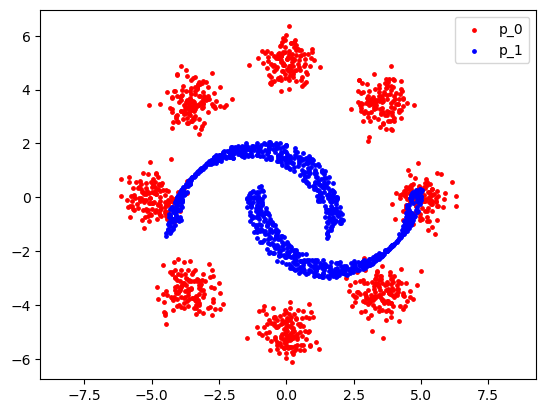

In [15]:
x = sample_8gaussians(1024)
y = sample_moons(1024)

plt.scatter(x[:,0],x[:,1], s = 6, color = 'red', label = "p_0")
plt.scatter(y[:,0],y[:,1], s = 6, color = 'blue', label = "p_1")
plt.axis('equal')
plt.legend()
plt.show()

## Expected Work

 - Train a MLP neural network (defined previously) defining a time dependant vector field that goes from $p_0$ to $p_1$. To do so, use the flow matching loss using the independent coupling.
 - Implement a Euler scheme to integrate this vector field, taking a large number of samples from $p_0$ and integrating the trajectory should ends to a distribution that looks like $p_1$.
 - Plot the trajectories followed by a these samples throughout the time integration. 

In [16]:
# TODO


## Optimal transport coupling (OTCFM)
Taking $\pi$ the independant coupling leads to curved trajectories, which is neither the most practical path to learn nor the easiest to integrate. The dynamical formulation of optimal transport tells us that the optimal path going from a density to another follows straight lines.
Since flow matching is conceived to scale well in high dimension, it is not reasonable to compute the exact optimal transport between $p_0$ and $p_1$. 
However we can try to approximate the optimal transport coupling and use that approximation to train our vector field.
The approximation we will use is called minibatch optimal transport, the idea is to compute exact optimal transport between batches of size $N$ of samples $(x_i)_{1 \leq i \leq N} \sim p_0$ and  $(y_i)_{1 \leq i \leq N} \sim p_1$ and use the coupling between those batches as an approximation of the coupling between the whole densities. 
The approximation becomes better as the batch size $N$ grows, but the computational complexity of exact OT being $\mathcal{O}(N^3)$, taking a large $N$ is not feasible.

**Expected Work**
 - Implement a function that compute the optimal transport map between two sets of points. You can for example use the library pot, in particular pot.emd (pot doc: https://pythonot.github.io/).
 - Adapt your flow matching algorithm to train the vector field using a minibatch OT coupling instead of an independent coupling for the loss.
 - Plot the trajectories of a set of samples from $p_0$ following this new flow. Unlike (ICFM), these trajectories should be almost straight.

In [1]:
#TODO


## Straighness of flow mathcing trajectories

To assess quality of the flow matching, an interesting metric is the "straightness" of the vector field along trajectories, for simplicity of implementation, the straightness $\kappa$ can be defined as the deviation from the straight pass:
$$  \kappa(\theta) = \int_{\mathbb{R}^d} \int_0^1 \| x_1 - x_0  -  v_\theta(t, x_t) \|^2 dt d p_0(x_0) $$
where $x_t$ can either be the trajectory of the flow from $x_0$ to $x_1$, or the linear interpolant between $x_0$ and $x_1$.

**Expected work**
 - Implement a straightness estimator for conditional flow matching.
 - Compare (ICFM) and (OTCFM) straightness estimators. 

In [2]:
# TODO
